# Download Data

In [1]:
import requests
import pandas as pd
from io import BytesIO

def download_csv(csv_url):
    response = requests.get(csv_url)
    response.raise_for_status()

    # Qui puoi modificare 'sep' o aggiungere altri parametri se necessario
    try:
        df = pd.read_csv(BytesIO(response.content), sep=',')
    except pd.errors.ParserError:
        df = pd.read_csv(BytesIO(response.content), sep=';', error_bad_lines=False)

    return df

In [2]:
recipes_df = download_csv("https://media.githubusercontent.com/media/DonatoFe11/SustainaMeal_Case_Study/master/data/final_recipes_set.csv")

In [3]:
recipes_df

,title,sustainability_score,sustainability_label,Unnamed: 0,recipe_id,description,author_id,duration,directions,ingredients,...,protein [g],direction_size,ingredients_sizes,who_score,fsa_score,nutri_score,normalization_comment,ingredient_food_kg_urls,ingredient_food_kg_names,healthiness_label
0,Boiled Radishes,0.002502,0,294268,179840,These taste a lot like new potatoes. The boil...,254469,22.0,"['Trim ends and bad spots off Radishes.', 'Boi...","['radishes size bag bunch', 'water radishes']",...,0.8,2,2,0.293040,1.000,0.75,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"['applesauce', 'garlic clove', 'ginger', 'mola...",0
1,Apple Cider Reduction,0.002623,0,59722,521756,I saw a post about this on Facebook and gave i...,171084,155.0,"['In 6-8 quart stock pan, measure out 2 cups o...","['gallon apple cider fresh', 'gallon apple cid...",...,0.0,10,2,0.214286,0.750,0.75,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"['bean sprouts', 'chicken thighs', 'fresh ging...",1
2,Homemade Apple Pectin Stock,0.002623,0,159910,25188,Easy to make and works well.,10404,25.0,['Slice unpeeled apples including cores and se...,"['tart apple', 'water pound apples']",...,1.2,11,2,0.278414,0.750,0.75,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"['baking powder', 'baking soda', 'cinnamon', '...",0
3,Easy Applesauce,0.002623,0,421226,264179,Use fresh cooking apples for this for best res...,37636,50.0,['Place apples and cider into a large saucepan...,"['apples', 'apple cider']",...,0.5,3,2,0.276525,0.875,0.75,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"['carrots', 'fresh peas', 'fresh tomatoes', 'g...",0
4,Cider Baked Sausage,0.002752,0,374088,101966,A very easy to make main dish perfect for fall...,30534,50.0,"['Preheat oven to 350°.', 'Prick sausages with...","['breakfast sausage links', 'apples Smith', 'o...",...,46.4,4,4,0.146714,0.125,0.00,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"['Shedd Spread Country Crock', 'cayenne pepper...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93743,Curried Lamb on Rice,0.951024,2,103145,373244,"With modification this recipe is from ""The Dia...",133174,65.0,"['Over medium heat, melt the butter in a large...","['lamb', 'medium onion', 'cloves', 'butter', '...",...,28.7,5,13,0.223549,0.625,0.25,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"['Dijon mustard', 'Polish sausage', 'apricot p...",1
93744,Rich Lamb Curry,0.960504,2,442694,268247,The recipe isn't as time consuming as it looks...,491437,110.0,"['Heat 1 tbsp olive oil in dutch oven. ', 'Co...","['oil', 'lamb', 'flour', 'salt pepper', 'onion...",...,36.1,9,21,0.153328,0.000,0.00,NaN,NaN,NaN,1
93745,"Middle Eastern Slow-Cooked Stew With Lamb, Chi...",0.968458,2,359960,144850,From Cooking Light. Per 3/4 c. serving: 310 ca...,37779,112.0,['Let the oil get heating in a large pot over ...,"['oil', 'lamb', 'onions rings', 'water', 'clov...",...,20.8,12,19,0.205566,0.250,0.25,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"['anchovies', 'celery ribs', 'diced tomatoes',...",1
93746,Five Meat Chili Con Carne With Beans,0.971454,2,37637,13568,yum,20571,210.0,"['In a large pot brown meat in stages, about a...","['beef', 'pork', 'lamb', 'sausage', 'sausage',...",...,14.5,7,15,0.197568,0.250,0.25,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"[""French\\'s French fried onions"", 'crabmeat',...",1


# SustainaMeal (ETA: 15/20 mins)

Initializes the system by loading the data and preparing the embeddings.

In [4]:
from HeASe.sustainameal import SustainaMeal

nutrients = ['calories [cal]', 'totalFat [g]', 'saturatedFat [g]', 'cholesterol [mg]', 'sodium [mg]', 'dietaryFiber [g]', 'sugars [g]', 'protein [g]']

sm = SustainaMeal(
    recipes_df=recipes_df,
    nutrients=['calories [cal]', 'totalFat [g]', 'saturatedFat [g]', 'cholesterol [mg]', 'sodium [mg]', 'dietaryFiber [g]', 'sugars [g]', 'protein [g]'],
    transformer_name='davanstrien/autotrain-recipes-2451975973'
)

/home/festa/SustainaMeal_Case_Study/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Processing Titles embeddings: 100%|██████████| 93748/93748 [14:24<00:00, 108.49batch/s]


# Upload Recipes of experiments

In [5]:
import pandas as pd

# Paths to the JSON files

sustainability_label_2_recipes_file = '../experiments/data/sustainability_label_2_recipes.json'

# Read the JSON files into pandas DataFrames

sustainability_label_2_recipes = pd.read_json(sustainability_label_2_recipes_file)


# Compare LLM Rerank

In [6]:
sm.setup_openai_key("opken-ai")

In [7]:
acceptable_tags = ['appetizers', 'main-dish', 'side-dishes', 'drinks', 'beverages', 'fruits', 'desserts',
                   'breakfast', 'pasta-rice-and-grains', 'rice', 'pasta', 'pizza', 'breads', 'meat', 'fish',
                   'seafood', 'beef', 'chicken', 'vegetarian']

In [8]:
nutrients_string = ", ".join(nutrients)
print(nutrients_string)


calories [cal], totalFat [g], saturatedFat [g], cholesterol [mg], sodium [mg], dietaryFiber [g], sugars [g], protein [g]


In [9]:
selected_recipes = pd.concat([sustainability_label_2_recipes])

In [10]:
len(selected_recipes)

100

In [11]:
# Definisci le soglie
WHO_SCORE_THRESHOLDS = ( 0.15, 0.25)  # (soglia media, soglia alta)
SUSTAINABILITY_SCORE_THRESHOLDS = (0.1, 0.5)  # (soglia media, soglia alta)

# Funzioni di aiuto per calcolare le label
def calculate_healthiness_label(who_score):
    if who_score > WHO_SCORE_THRESHOLDS[1]:
        return "0"
    elif who_score < WHO_SCORE_THRESHOLDS[0]:
        return "2"
    else:
        return "1"

def calculate_sustainability_label(sustainability_score):
    if sustainability_score <= SUSTAINABILITY_SCORE_THRESHOLDS[1]:
        return "0"
    elif sustainability_score >= SUSTAINABILITY_SCORE_THRESHOLDS[1]:
        return "2"
    else:
        return "1"

# Calcola le label in base ai valori di who_score e sustainability_score

In [12]:
similar_recipes = sm.find_similar_recipes("Pasta", 10, acceptable_tags=acceptable_tags, match_all_tags=False)

Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 44.05batch/s]

Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 40632


In [13]:
ordered_recipes = sm.order_recipe_by_sustainameal()
print(ordered_recipes)

                                                   title  similarity_score  \
14718                             Brown Rice and Edamame          0.983478   
15242  Tofu With Red Curry Paste, Peas, and Yellow To...          0.987000   
10896                Pasta with Tomatoes, Peas and Cream          0.989872   
27313                                          Tofu Bowl          0.982967   
47161                       Asparagus-Mushroom Primavera          0.989029   
59687         Angel Hair With Tomatoes, Basil and Garlic          0.983265   
65588                  Spaghettini With Smothered Onions          0.983291   
60293                    Orlando Bloom's Pasta Au Pistou          0.985503   
68061               Mini Farfalle With Tomatoes and Corn          0.991634   
79355                Pasta and Potatoes (Pasta e Patate)          0.984892   

       who_score  healthiness_increment  sustainability_score  \
14718   0.345328              47.711098              0.909384   
15242   0.3

In [14]:
ordered_recipes_gpt = sm.order_recipe_by_sustainameal()
print(ordered_recipes_gpt)

                                                   title  similarity_score  \
14718                             Brown Rice and Edamame          0.983478   
15242  Tofu With Red Curry Paste, Peas, and Yellow To...          0.987000   
10896                Pasta with Tomatoes, Peas and Cream          0.989872   
27313                                          Tofu Bowl          0.982967   
47161                       Asparagus-Mushroom Primavera          0.989029   
59687         Angel Hair With Tomatoes, Basil and Garlic          0.983265   
65588                  Spaghettini With Smothered Onions          0.983291   
60293                    Orlando Bloom's Pasta Au Pistou          0.985503   
68061               Mini Farfalle With Tomatoes and Corn          0.991634   
79355                Pasta and Potatoes (Pasta e Patate)          0.984892   

       who_score  healthiness_increment  sustainability_score  \
14718   0.345328              47.711098              0.909384   
15242   0.3

In [15]:
best_choice_by_gpt = sm.choose_best_recipe_with_gpt()

1. Recipe: Brown Rice and Edamame
2. Recipe: Tofu With Red Curry Paste, Peas, and Yellow Tomatoes
3. Recipe: Asparagus-Mushroom Primavera
4. Recipe: Tofu Bowl
5. Recipe: Mini Farfalle With Tomatoes and Corn
6. Recipe: Pasta with Tomatoes, Peas and Cream
7. Recipe: Angel Hair With Tomatoes, Basil and Garlic
8. Recipe: Spaghettini With Smothered Onions
9. Recipe: Pasta and Potatoes (Pasta e Patate)
10. Recipe: Orlando Bloom's Pasta Au Pistou

Choose: Brown Rice and Edamame


In [16]:
import json
import pandas as pd

# Assumi che 'SustainaMeal', 'acceptable_tags', 'nutrients_string', e 'recipe_titles' siano definiti

# Parametri per gli esperimenti
k_values = [10]
match_all_tags_values = [False]

# Funzione ausiliaria per convertire oggetti in formati serializzabili in JSON
def convert_to_serializable(obj):
    if hasattr(obj, 'to_dict'):
        return obj.to_dict('records')
    elif hasattr(obj, 'tolist'):
        return obj.tolist()
    elif isinstance(obj, (list, dict, str, int, float, bool, type(None))):
        return obj
    else:
        return str(obj)

results = []  # Lista per raccogliere i risultati degli esperimenti

for index, row in selected_recipes.iterrows():
    input_recipe = row['title']
    match_results = {}  # Dizionario per memorizzare i risultati di match per ogni k
    for k in k_values:
        match_results[k] = {'exact_match': False, 'match_count': 0}  # Inizializza il conteggio e il match esatto per ogni k
        for match_all_tags in match_all_tags_values:
            try:
                similar_recipes = sm.find_similar_recipes(input_recipe, k, acceptable_tags=acceptable_tags, match_all_tags=match_all_tags)
                ordered_recipes = sm.order_recipe_by_sustainameal()
                ordered_recipes_gpt = sm.order_recipe_by_sustainameal()

                best_choice_by_gpt = sm.choose_best_recipe_with_gpt()
                gpt_choice_match = ordered_recipes.iloc[0]['title'] == best_choice_by_gpt
                if gpt_choice_match:
                    match_results[k]['match_count'] += 1
                    if match_all_tags:  # Se consideri importante il match quando match_all_tags è True
                        match_results[k]['exact_match'] = True
                result = {
                    'recipe_name': input_recipe,
                    'recipe_id': row['recipe_id'],
                    'sustnability_score': row['sustainability_score'],
                    'sustnability_label': row['sustainability_label'],
                    'who_score': row['who_score'],
                    'healthiness_label': row['healthiness_label'],
                    'k': k,
                    'nutrients': nutrients_string,
                    'match_all_tags': match_all_tags,
                    'gpt_choice': best_choice_by_gpt,
                    'similar_recipes': convert_to_serializable(similar_recipes) if similar_recipes is not None else None,
                    'ordered_by_sustainameal': convert_to_serializable(ordered_recipes) if ordered_recipes is not None else None
                }
                results.append(result)
            except Exception as e:
                print(f"An error occurred while finding similar recipes: {e}")
                best_choice_by_gpt = None



    # Calcola la percentuale di similarità per ogni k e aggiungi ai risultati
    # for k, match_info in match_results.items():
    #     match_info['similarity_percentage'] = (match_info['match_count'] / len(match_all_tags_values)) * 100
    #     results.append({
    #         'recipe_name': input_recipe,
    #         'k': k,
    #         'exact_match': match_info['exact_match'],
    #         'similarity_percentage': match_info['similarity_percentage']
    #     })

# Salva i risultati in un file JSON
with open('experiment_results_with_gpt_and_similarity_k_10.json', 'w') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.02batch/s]

Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Based on a balance of sustainability and healthiness, the most recommended recipe is "Italian Chicken and Artichokes."


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.80batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344
1. Recipe: Delicious Vegetable Lasagna
2. Recipe: Linguine With Marinara Sauce and Meatballs
3. Recipe: Delicious Game Day Beef Stew
4. Recipe: Amager Island Stew (Amagergryde)
5. Recipe: Bewitching Chili
6. Recipe: Hamburger Hot Pot (crock Pot)
7. Recipe: Asparagus, Cabbage and Chicken or Chicken Stir-Fry
8. Recipe: Easy & Yummy Slow Cooker Chicken
9. Recipe: Quick Meatball Lasagna
10. Recipe: Mandarin Pork

You should choose: Recipe: Delicious Vegetable Lasagna


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 97.68batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345
1. Recipe: Portuguese Shrimp and Scallops
2. Recipe: Cream of Spinach n' Shrimp Over Pasta
3. Recipe: Lary's Juicy Meatballs
4. Recipe: Momosita's Amazing Ground Turkey/Chicken Meatloaf (With Hidden V
5. Recipe: Hubby's Baked Boneless Chicken Wings
6. Recipe: Simple Breaded Chicken Drumsticks
7. Recipe: Broccoli and Ham Stuffed Chicken Breasts
8. Recipe: Italian Meatloaf Patties
9. Recipe: Jalapeno Popper Chicken
10. Recipe: Sausage Brunch Bake

You should choose Portuguese Shrimp and Scallops.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 94.94batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Avocado BLT Salad  
2. Recipe: Asparagus Bundles or Green Bean Bundles  
3. Recipe: BLT Salad With Avocado Dressing  
4. Recipe: Vietnamese Beef Stir-Fry With Lychees  
5. Recipe: Smoked Chicken and Vegetable Chowder  
6. Recipe: Cheesy Potato Casserole (Crockpot)  
7. Recipe: 2Bleu's Zucchini & Yellow Squash Casserole  
8. Recipe: Turkey breasts with brandy sauce  
9. Recipe: Spicy Bacon, Spinach and Artichoke Dip  
10. Recipe: Red Led and Hat Tally's

Based on a balance of sustainability and healthiness, I recommend choosing the "Avocado BLT Salad."


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 86.45batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345
Based on a balance of sustainability and healthiness, the most recommended recipe is: 92306. Recipe: Baked Cheeseburgers.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.74batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Based on a balance of sustainability and healthiness, you should choose: Recipe: Seared Chicken Thighs With Plum Glaze


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.22batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436
Based on a balance of sustainability and healthiness, you should choose the "Grilled Vietnamese Beef Skewers" recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 90.99batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Based on a balance of sustainability and healthiness, you should choose the recipe: Tofu-Veggie Lasagna (84286. Recipe: Tofu-Veggie Lasagna).


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.57batch/s]


Tags to match: ['main-dish', 'beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344
Based on a balance of sustainability and healthiness, I recommend choosing the "Hippie Cornbread" recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 80.45batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345
Smaller Lasagna for Two


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.14batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Recipe: Root Beer Chicken


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 81.00batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
59039. Recipe: Tomato Basil Roasted Chicken


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 103.36batch/s]


Tags to match: ['breakfast', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34846
Make Ahead Italian Sausage and Pasta Bake


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.21batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Grits and Sausage Bake
2. Recipe: Pork Stew With Celery
3. Recipe: Chicken Simon and Garfunkel
4. Recipe: Elegante Chicken Piccata
5. Recipe: Veal Scaloppine With Tomatoes
6. Recipe: Pork Tenderloin With Parmesan Crust
7. Recipe: Low Carb Salmon Au Gratin
8. Recipe: Five Star Chile Rellenos Casserole
9. Recipe: Meatballs in Beer
10. Recipe: Jake's Easy Cheesy Bacon Meatloaf

Choose "Grits and Sausage Bake" for a balanced option in terms of sustainability and healthiness.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.61batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Indian Moghul Chicken Biryani
2. Recipe: Jambalaya (Authentic)
3. Recipe: Homemade Pastrami (Crockpot)
4. Recipe: Easy Mini Meat Loaves
5. Recipe: Jambalaya w/shrimp, chicken and sausage
6. Recipe: Corned Beef With Mustard Glaze
7. Recipe: Ruby-Glazed Corned Beef
8. Recipe: Corned Beef With a Plum Glaze (Slow Cooker)
9. Recipe: Miriam Reichl's Corned Beef Ham
10. Recipe: New Zealand Corned Beef Hot Pot

Based on a balance of sustainability and healthiness, you should choose "Indian Moghul Chicken Biryani."


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.03batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937
Here is the ranked list of recipes based on a balance of sustainability and healthiness:

1. Recipe: Paprika Chicken With Cannellini Beans, Quick & Easy
2. Recipe: Slow-Cooked Lamb Shanks With Lentil Ragout
3. Recipe: Hearty Barley and Chicken Casserole
4. Recipe: Crock Pot Black Bean Salsa Chicken (Oamc)
5. Recipe: Tuscan Beef Stew (Crock Pot)
6. Recipe: Wendy's Copycat Chili
7. Recipe: Chicken With Smashed Baby Red Potatoes Pot Pie Style
8. Recipe: A & L Chicken Pasta Casserole
9. Recipe: Pasta, Chicken With Spice
10. Recipe: Seared Chilean Sea Bass and Lobster With Thyme Scented Tomato

Based on this ranking, I recommend choosing the "Paprika Chicken With Cannellini Beans, Quick & Easy" recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.57batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Based on a balance of sustainability and healthiness, the recommended recipe to choose is "Salmon Patties With Lemon Sauce."


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 96.92batch/s]


Tags to match: ['appetizers', 'main-dish', 'seafood']
Number of filtered recipes: 32250
1. Recipe: Korean Fried Chicken (Soy and Garlic)
2. Recipe: Super Sesame Chicken Wings
3. Recipe: Skillet Chicken Pilaf
4. Recipe: Ono Chicken Wings
5. Recipe: Chinese Pot Roasted Chicken
6. Recipe: Chicken Hurry
7. Recipe: Ga Gone Thai
8. Recipe: Grandma Landers's Chicken 'n' Rice
9. Recipe: Melt in Your Mouth Chicken Pan Pie

You should choose: Korean Fried Chicken (Soy and Garlic)


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 83.13batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34526
I recommend choosing "Shrimp & Grits".


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 83.70batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375
1. Recipe: Slow Cooker Mediterranean Chicken With Sun Dried Tomatoes


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 87.55batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Broccoli and Lemon Pepper Chicken Alfredo With Bow Tie Pasta


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 82.50batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 23411
1. Recipe: Finnish Meatballs - Lihapyorykoita
2. Recipe: Mom's Beef Stroganoff
3. Recipe: Champion Casserole

Based on a balance of sustainability and healthiness, you should choose "Finnish Meatballs - Lihapyorykoita."


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 84.62batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Recipe: Vegetarian Southwest Lasagna


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.59batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375
1. Recipe: Main Course (Hamburger) Soup
2. Recipe: Gjelle Me Zarzavata (Albanian Casserole)
3. Recipe: Baked Chicken Kabobs
4. Recipe: Round Steak Supper
5. Recipe: Taco Stuffed Pasta Shells
6. Recipe: Crock Pot Chicken and Stuffing Dinner
7. Recipe: Pasta Sauce Spaghetti Soup (Crock Pot or Stove Top)
8. Recipe: Perruso's Spaghetti and Meatballs
9. Recipe: Brownie Special

I recommend choosing "Main Course (Hamburger) Soup" for the best balance of sustainability and healthiness.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 99.69batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622
I would recommend choosing the "Magical Moroccan Chicken and Chickpeas" recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.32batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345
Based on a balance of sustainability and healthiness, I recommend choosing the **Broccoli, Cheese, Rice Casserole With Chicken** recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 81.34batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345
1. Recipe: Turkey Breast With Apricot Sausage Stuffing
2. Recipe: My Pot Roast
3. Recipe: Delicious Chicken Paella
4. Recipe: Homemade Pork Sausage W/ Rigatoni & Baby Spinach
5. Recipe: Sesame Garlic Sirloin Steak
6. Recipe: Stroganoff Casserole
7. Recipe: Creamy Pork Chops, Mushroom and Potato Casserole
8. Recipe: Tortilla Beef
9. Recipe: Baked Hamburger Patties With Pasta Sauce
10. Recipe: Melting Meatballs with Pasta

Based on a balance of sustainability and healthiness, you should choose "Turkey Breast With Apricot Sausage Stuffing."


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 83.70batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622
I recommend choosing the recipe for Easy Oven Vegetable and Beef Stew.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.18batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Spinach and Ricotta Pie
2. Recipe: Kotlety Pozharskie (Russian Ground Chicken Cutlets)
3. Recipe: Stuffed Chicken Breast in a White Wine Cream Sauce
4. Recipe: Pork Tenderloin W/  Salad and Honey and Mustard Dressing
5. Recipe: Salmon in pastry with herb and cream sauce
6. Recipe: Chicken and Mushrooms over Noodles
7. Recipe: Creamy Italian Chicken Puff Pie
8. Recipe: Cheeseburger Meatloaf and Mashed Potatoes
9. Recipe: Blue Cheese Meatloaf
10. Recipe: Texas Casserole

I recommend choosing the "Spinach and Ricotta Pie."


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.47batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Chicken Breasts Stuffed with Goat Cheese, Basil and Red Pepper
2. Recipe: Spinach & Sausage Stuffed Pasta Shells
3. Recipe: Quick Bolognese Sauce

I recommend choosing the Chicken Breasts Stuffed with Goat Cheese, Basil and Red Pepper recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.74batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Olive Garden Tuscan Garlic Chicken
2. Recipe: Creamy Turkey-Corn Chowder
3. Recipe: Turkey and Artichoke Stuffed Shells
4. Recipe:Another Baked Ziti
5. Recipe: Meatballs (Polpetti) & Sunday Gravy
6. Recipe: Cheesy Stuffed Shells W/ Semi-Homemade Sauce
7. Recipe: Beef 'n Bean Burrito Stack (Crock Pot, Slow Cooker)
8. Recipe: Shepherd's Hash Brown Pie
9. Recipe: Hot and Spicy Chili
10. Recipe: Rudy's at the Loop Texas Hot Sauce

I recommend choosing the **Olive Garden Tuscan Garlic Chicken** recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.97batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Fresh Tomato-Basil-Asparagus Pasta Salad


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.50batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Salmon with Pistachio Basil Butter


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 72.39batch/s]


Tags to match: ['main-dish', 'side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 39608
1. Recipe: Baby Bok Choy Stir-Fry
2. Recipe: Roasted Italian Asparagus With Parmesan
3. Recipe: Grilled Sesame Asparagus

Choose "Baby Bok Choy Stir-Fry".


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.69batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
61595. Recipe: End of Summer Ratatouille


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.68batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345
Here is the ranked list based on a balance of sustainability and healthiness:

1. Recipe: Hearty Beef and Vegetable Soup
2. Recipe: Chicken & Black Bean Soup
3. Recipe: Better Butter Beans
4. Recipe: Wonderful Chili
5. Recipe: Heidi's Famous Chili
6. Recipe: Taco Soup (Paula Deen)
7. Recipe: My sister, Ruth Kamps Texas Soup
8. Recipe: Hearty Baked Bean Casserole
9. Recipe: Jen's Tostada Pizza
10. Recipe: Chili Like at That Place Dave Named After His Daughter Copycat

You should choose "Hearty Beef and Vegetable Soup."


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 89.00batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937
70323. Recipe: Tuscan Roast Chicken With Tomatoes, Zucchini and Olives


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 102.47batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 23411
Scandinavian Meatballs and Gravy


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 81.81batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622
Based on a balance of sustainability and healthiness, the recommended recipe would be:
29530. Recipe: Cedar Plank Salmon With Ginger Sauce


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.27batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 26549
The most recommended recipe based on a balance of sustainability and healthiness is: Recipe: Cheesy Asparagus and Egg Casserole.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 82.76batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Tomato, Basil, Yogurt Tart


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 80.41batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Stuffed Poblano Peppers (Oamc)


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.65batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622
Recipe: Pork, Cashew, and Green Bean Stir Fry


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 93.54batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
The most recommended recipe based on a balance of sustainability and healthiness is "Chicken Thighs With Beans , Mushrooms and Tomatoes" (Recipe number: 77963).


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 88.00batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334
1. Recipe: Pasta With Salmon and Dill
2. Recipe: Salmon With Rice-Florentine
3. Recipe: Sun-Dried Tomato and Chicken Lasagne
4. Recipe: Peppered Lemon Chicken Pasta
5. Recipe: Spinach Lasagna (Easy No-Boil Method)
6. Recipe: Taco One Skillet Meal
7. Recipe: Chicken and Cheese Filled Squash Ravioli
8. Recipe: Babi Ketjap
9. Recipe: Layered Mini Lasagne Casserole
10. Recipe: Baked Ham & Noodle Supper

You should choose "Pasta With Salmon and Dill."


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.97batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Based on a balance of sustainability and healthiness, the recommended recipe is:
"84383. Recipe: Mmmm Veggie Pie!"


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.77batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344
1. Recipe: Forty Clove Garlic Chicken
2. Recipe: Pork Chops With Garlic and Apples in Wine
3. Recipe: Low Carb Chicken Broccoli Alfredo
4. Recipe: Mince Beef Curry
5. Recipe: Pork 'n' Tater Skillet
6. Recipe: Taco Taters
7. Recipe: Tuna Au Poivre (Tuna With Ground Black Pepper)
8. Recipe: "Drunken" Pork Chops
9. Recipe: Lucille Ball Special
10. Recipe: Fairwell Family Secret Meatball Recipe

Choose Forty Clove Garlic Chicken.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.29batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Based on a balance of sustainability and healthiness, the recommended recipe is: 
Recipe: #1 Favorite Chinese Steamed Whole Fish by Sy


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.02batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345
Thai Basil Beef


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.05batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Chicken Breasts With Vinegar Sauce (Guyana -- Caribbean)
2. Recipe: Solo Baked Chicken Breast
3. Recipe: Easy Baked Meatballs With Two Sauce Options

Based on a balance of sustainability and healthiness, you should choose the "Chicken Breasts With Vinegar Sauce (Guyana -- Caribbean)" recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.84batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Based on a balance of sustainability and healthiness, you should choose the "Low Carb Broccoli Bacon Salad" recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.17batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375
Here are the recipes ranked from most to least recommended based on a balance of sustainability and healthiness:

1. Recipe: Simple and delicious stove top mushroom gravy pork chops
2. Recipe: Marinated Baked Pork Chops
3. Recipe: Crock Pot Juicy Pork Chops
4. Recipe: Bruce's Crock Pot Pepperoncini Roast Sandwich
5. Recipe: Sarah's Famous Burgers
6. Recipe: Hamburger Patties Saucy Style
7. Recipe: Taco Nite
8. Recipe: Hot Beef Sandwich Au Jus
9. Recipe: Baked Buffalo Chicken Breasts
10. Recipe: Spicy Chicken Spaghetti

You should choose the "Simple and delicious stove top mushroom gravy pork chops" recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.85batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Barley Stroganoff Stew (93522)
2. Chicken Spinach Mexiwraps (82851)
3. Baked Ziti (93146)
4. Ham & Broccoli Crock Pot Casserole (74668)
5. Meaty Pasta Casserole (93369)


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 98.15batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Eggplant Minestrone  
2. Recipe: Brothy Split Pea & Ham Soup  
3. Recipe: Three Bean Award Winning Chili  
4. Recipe: Mawthook's Beefy Chili  
5. Recipe: Sarah's Best Chili Recipe  

I recommend choosing the "Eggplant Minestrone" recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.58batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375
Recipe: Chicken and Chickpea Salad


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 80.49batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345
1. Recipe: Linguine Pesto With Italian Chicken Strips
2. Recipe: Chicken, Saffron Risotto (Low Fat)
3. Recipe: Chicken and Rice Skillet
4. Recipe: Pineapple and Chicken Rice Salad
5. Recipe: Kotopoulo Makaronada (Chicken Pasta)
6. Recipe: Moroccan Pasta Salad With Tuna
7. Recipe: Tuna Hotdish
8. Recipe: Scallop and Asparagus Linguine
9. Recipe: Tuna Fish and Spaghetti Casserole
10. Recipe: Beef & Macaroni Dinner

You should choose: Recipe: Linguine Pesto With Italian Chicken Strips


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.30batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Based on a balance of sustainability and healthiness, the recommended recipe is:
69201. Recipe: Pasta with Chicken and Pepper Cheese Sauce


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 102.06batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
I recommend the recipe: Seasoned Stuffed Bell Peppers.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 95.58batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937
I suggest choosing the recipe: Ground Beef and Wild Rice Casserole.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 81.95batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937
Here is the list ranked from most to least recommended based on a balance of sustainability and healthiness:

1. Recipe: The Best Jambalaya
2. Recipe: Company Chicken Salad Casserole
3. Recipe: Scottish Lorne Sausages: Square Breakfast Sausage!
4. Recipe: Grilled Pork Chops Marinade
5. Recipe: Taste of Asia Steak Marinade
6. Recipe: Roast Peppered Rib Eye of Beef
7. Recipe: Saucy Forgotten Beef
8. Recipe: Bacon Jalapeno Burgers With Chipotle Mayonnaise
9. Recipe: Chicken Glop
10. Recipe: Trisha Yearwood's Cowboy Lasagna

Therefore, you should choose **The Best Jambalaya** recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 80.79batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622
Here is the recommended recipe based on a balance of sustainability and healthiness:
Recipe: Easy Asian Noodle Dish


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.39batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Chicken With Cucumbers and Mushrooms
2. Recipe: Mussels in Herbed Cream Sauce
3. Recipe: Jalapeño Garlic Tilapia Panini
4. Recipe: Stuffed Italian Pork Chops
5. Recipe: Easy Turkey Casserole

You should choose "Chicken With Cucumbers and Mushrooms."


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 83.41batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Haddock Provencal


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.58batch/s]


Tags to match: ['beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 26857
Choose the Chili-Rubbed Chicken With Roasted Garlic Sauce recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 82.68batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
In terms of sustainability and healthiness, the recommended recipe to choose is: Recipe: Chicken and Chickpea Salad


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.27batch/s]


Tags to match: ['main-dish', 'beef', 'pizza', 'meat']
Number of filtered recipes: 28937
1. Recipe: West African Lemony Chicken-Okra Soup  
2. Recipe: Sesame Beef and Asparagus Stir Fry  
3. Recipe: Grilled Beef Fajitas With Avocado Pico De Gallo  
4. Recipe: Creamy Crock-Pot Chicken Noodle Soup  
5. Recipe: Ham & Asparagus Pie  
6. Recipe: Jambalaya Stuffing  
7. Recipe: Maggiano's Little Italy Chicken Asiago Soup (Copycat)  
8. Recipe: Canadian Bacon Bow Ties  
9. Recipe: A Better Marzetti  
10. Recipe: Chef Boyardee Beef Ravioli

Choose "West African Lemony Chicken-Okra Soup" as the most recommended option for a balance of sustainability and healthiness.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.36batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Broccoli Stuffed Meatloaf
2. Mary's Baked Italian Meatballs
3. Porcupine Meatloaf Crock Pot
4. Mom's Best Meatloaf
5. Mushroom Meatballs
6. Muffin Tin Meat Loaves
7. Special Meatloaf With Heinz 57 Sauce
8. So Simple Onion Barbecued Burgers
9. Pvw's Garlic Citrus Chicken
10. Weight Watchers Veal Piccata

Choose Broccoli Stuffed Meatloaf.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 83.16batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Based on a balance of sustainability and healthiness, you should choose the "Baked Greek Lemon Chicken" recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.98batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Based on a balance of sustainability and healthiness, you should choose:

Recipe: Cauliflower, Swiss Chard, and Chicken Soup


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 81.78batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
From most to least recommended based on sustainability and healthiness:

1. Recipe: Spagagña
2. Recipe: "string Pie"
3. Recipe: Saucy Spaghetti Pie
4. Recipe: Famous Meatloaf
5. Recipe: Gramma's Meatloaf

Choose "Spagagña."


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 91.70batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Chicken and Vegetable Bean Soup
2. Recipe: Spicy Black-Eyed Pea Skillet
3. Recipe: Easy Mediterranean Chicken
4. Recipe: Taco in a Bowl
5. Recipe: Picky Mike's Goulash
6. Recipe: Aunt Annie's Chicken Chili
7. Recipe: Rogene's Taco Soup
8. Recipe: Simple Cincinnati Chili
9. Recipe: Slow-Cooker Hearty Beef Chili
10. Recipe: Taco Chili (Paula Deen)

Based on a balance of sustainability and healthiness, you should choose the recipe for Chicken and Vegetable Bean Soup.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 103.94batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Shrimp & Grits

2. Recipe: Greek Feta Casserole

3. Recipe: Very Tasty Swedish Meatballs

4. Recipe: Crunchy Parmesan Chicken

5. Recipe: Clams Au Gratin

6. Recipe: Simple Chicken Cordon Bleu

7. Recipe: Low Carb Cheeseburger Quiche

8. Recipe: Low Carb White Castle Casserole

Based on a balance of sustainability and healthiness, you should choose: Shrimp & Grits.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.74batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
I recommend choosing the "30 Minute Chicken and Rice Dinner by Accident" recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 82.46batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345
Based on a balance of sustainability and healthiness, I recommend choosing the "Shepherd’s Pie Jackets" recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 88.40batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Based on a balance of sustainability and healthiness, the most recommended recipe is: Recipe: Broccoli Chicken Divan Cups.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 83.06batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622
Here are the recipes ranked based on sustainability and healthiness:

1. Recipe: shrimp w/shredded zucchini
2. Recipe: Sausage Brunch Bake
3. Recipe: Chicken Loaf With Mushroom Sauce
4. Recipe: Shrimp Quickie
5. Recipe: Salisbury Steak for 2

You should choose the "shrimp w/shredded zucchini" recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.44batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
I recommend choosing the **Recipe: Chicken, Lentil, Potato Curry**.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.55batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Klein's Chicken
2. Recipe: Pork Chops With Orange Rice
3. Recipe: Korean Barbecue Burgers
4. Recipe: Easy Italian BBQ Chicken Pizza
5. Recipe: 20 Minute Pork Chops Mornay
6. Recipe: German-Style Hamburgers
7. Recipe: Iowa-Style Loose Meat Sandwiches
8. Recipe: B-B-Q Meatloaf
9. Recipe: Country Sloppy Joes
10. Recipe: Star-Spangled Cheeseburgers

You should choose "Klein's Chicken".


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 84.84batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Pesto Penne With Roasted Chicken
2. Recipe: Low Sodium Simple Chili
3. Recipe: Ratatouille Meatballs
4. Recipe: Chocolate Chili with Apples
5. Recipe: Cowboy Ground Chuck Stew
6. Recipe: Dutch Oven Pork Chops And Potatoes
7. Recipe: English Beef Stew and Dumplings
8. Recipe: Pork Chop - Potato Casserole
9. Recipe: Chicken With Black Beans over Pasta
10. Recipe: Crock Pot Shipwreck Ground Beef Stew

Based on sustainability and healthiness, you should choose "Pesto Penne With Roasted Chicken."


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 82.69batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
I recommend choosing the recipe for Chicken & Eggplant (Aubergine) Parmesan.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.02batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Lamb Stew (Navarin of Lamb)  
2. Recipe: Spicy Grilled Tilapia W/ Creamy Grits or Rice and Mushroom Sauce  
3. Recipe: Potato-Topped Beef Casserole  
4. Recipe: Guacamole Cheeseburgers


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 81.95batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
The recommended recipe is: Nutty Drunken Cod


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 80.97batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 11479
1. New Orleans Spinach Garlic Bread
2. Italian Egg Rolls
3. Mock Sliders (White Castles)
4. Fried Mozzarella Wedges W/ Homemade Marinara
5. Open-Face Crab and Artichoke Melt
6. Recipe: Jan's Pizza Bread
7. Shrimp Caesar Sandwich
8. Buffalo Wing Tuna Sandwich
9. Arielle's Favorite Tuna Casserole
10. TOASTED BUTTERY TUNA MELT!!!

Choose New Orleans Spinach Garlic Bread.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.09batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Chicken, Asparagus and Caramelized Onions
2. Recipe: Basil Chicken With Broccoli
3. Recipe: Light and Tangy Chicken and Feta Salad
4. Recipe: Roasted Chicken, Artichoke, Feta and Orzo Salad
5. Recipe: Low-Carb Slaw
6. Recipe: Zucchini-Beef Italian
7. Recipe: Beef - Mushroom Ragu over Fresh Cheese Ravioli
8. Recipe: Stuffed Bell Pepper Casserole
9. Recipe: Ricardo's Bolognese Sauce
10. Recipe: Boursin Cheese and Bacon Stuffed Chicken Breasts - for Two!

I recommend you choose "Chicken, Asparagus and Caramelized Onions."


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.46batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Based on a balance of sustainability and healthiness, the most recommended recipe is "Chicken Scaloppine With Saffron Cream Sauce - Giada".


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.53batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Italian Greens and Beans With Sausage Variation


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 84.58batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622
66181. Recipe: Broccoli, Spinach and Chicken Casserole


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 81.63batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436
1. Recipe: Skinny Cajun Chicken Penne
2. Recipe: Chicken Couscous With Sun-Dried Tomatoes
3. Recipe: Welsh Chicken, Leek and Broccoli Casserole
4. Recipe: Pico De Gallo Seared Ahi

Choose: Skinny Cajun Chicken Penne


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.97batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Malay Marinade for Grilled Pork
2. Recipe: Uncle Bill's Salmon Marinated in Maple Syrup and Soy Sauce
3. Recipe: Christmas Ham in the Slow Cooker

Choose: Malay Marinade for Grilled Pork


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.15batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344
Based on a balance of sustainability and healthiness, the recommended recipe to choose is: 

84532. Recipe: Cheesy Eggplant (Aubergine) Marinara


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 80.82batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
Based on a balance of sustainability and healthiness, I recommend the recipe: Zucchini Beef Italiano.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 91.76batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Cheesy Asparagus Casserole
2. Recipe: Ham and Cheese Savory Dutch Baby
3. Recipe: Richard Anderson's Special Scrambled Eggs
4. Recipe: Chile Relleno Omelet
5. Recipe: Frittata Di Spaghetti (Spaghetti Omelet)
6. Recipe: Sausage and Pepper Frittata
7. Recipe: Camper's Breakfast Hash
8. Recipe: Brie & Bacon Omelet (Treasure Trove #10)
9. Recipe: Ham Omelet Deluxe
10. Recipe: Eggs for Dinner

Choose: Cheesy Asparagus Casserole


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 56.92batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Chicken Salad With Grapes and Apples


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 88.12batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34526
1. Recipe: Ziti With Sausage and Broccoli
2. Recipe: Southwestern Pita Pockets
3. Recipe: Quick Cheesy Chicken Enchiladas
4. Recipe: Baked Spaghetti (Cheesy & Spicy)
5. Recipe: Mom's Hammy Macaroni N' Cheese
6. Recipe: Creamy Cheesy Ham and Pasta
7. Recipe: Spicy Salsa Mac & Beef
8. Recipe: Ground Beef Oriental
9. Recipe: Grilled Ham and Gouda Sandwich W/Caramelized Onions

Based on a balance of sustainability and healthiness, you should choose the "Ziti With Sausage and Broccoli" recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.68batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Chicken Meatballs with Tomato Ginger Sauce
2. Mother and Child Reunion
3. Alabama White Barbecue
4. Irish Pub Meatloaf
5. Kittencal's Rotisserie Chicken for the Grill (Or Small Turkey)
6. Chicken and Cheese Pie
7. Meatloaf My Version
8. Pucker-Up Chicken
9. Southern Fried Chicken with Cream Gravy
10. Bacon Cheeseburger Balls

Based on a balance of sustainability and healthiness, you should choose "Chicken Meatballs with Tomato Ginger Sauce".


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.52batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
I recommend choosing the "Asparagus Penne" recipe.


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 86.40batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937
Based on a balance of sustainability and healthiness, you should choose the "Low Carb Savory Italian Grilled Chicken" recipe (71519).


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.68batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937
1. Recipe: Easy Chicken Almondine
2. Recipe: Alice's Baked Chicken Breast
3. Recipe: Baked Chicken and Wine
4. Recipe: Clahan's Jersey Beef
5. Recipe: Beef Dinner
6. Recipe: Pastitsio (Better Than Spaghetti)
7. Recipe: Pollo Fundido
8. Recipe: Linda's Tagborinni
9. Recipe: Simply Delicious Lasagna
10. Recipe: Creamy Cheesy Lobster Cavatappi

Choose "Easy Chicken Almondine".


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.41batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436
Here is the recommended recipe based on a balance of sustainability and healthiness:

93259. Recipe: Easy Crock Pot Lasagna


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.83batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344
1. Sensational Spinach Stuffed Shells
2. Beef Lombardi
3. Stuffed Bell Pepper Stew
4. Almost Taco Bell Famous Tacos (In Our House!!)
5. Chicken Soup With Gouda
6. Yum Nua - Thai Beef Salad
7. Wor Won Ton Soup
8. Cheesy Ham and Sweet Potato Casserole
9. Quick Ham and Potato Scallop
10. Rice and Ham Casserole

Choose: Sensational Spinach Stuffed Shells


In [17]:
len(results)

100

In [18]:
import json
import pandas as pd

# Carica i dati dal file JSON
with open('experiment_results_with_gpt_and_similarity_k_10.json', 'r') as file:
    experiment_data = json.load(file)

# Converti i dati in un DataFrame
experiment_df = pd.DataFrame(experiment_data)

# Assumiamo di avere gli ID delle ricette per ogni sottogruppo
sustainability_label_2_ids = sustainability_label_2_recipes['recipe_id'].unique()


In [19]:
import json
import pandas as pd

# Carica i dati dal file JSON
with open('experiment_results_with_gpt_and_similarity_k_10.json', 'r') as file:
    experiment_data = json.load(file)

# Converti i dati in un DataFrame
experiment_df = pd.DataFrame(experiment_data)

# Estrai solo le entrate dove GPT ha fatto una scelta
gpt_choices_df = experiment_df.dropna(subset=['gpt_choice'])

# Inizializza i contatori per gli incrementi
healthiness_increments = []
sustainability_increments = []
sustainameal_score_increments = []

# Calcola gli incrementi solo per le scelte di GPT
for index, row in gpt_choices_df.iterrows():
    for ordered_recipe in row['ordered_by_sustainameal']:
        if ordered_recipe['title'] == row['gpt_choice']:
            healthiness_increments.append(ordered_recipe['healthiness_increment'])
            sustainability_increments.append(ordered_recipe['sustainability_increment'])
            sustainameal_score_increments.append(ordered_recipe['sustainameal_score_increment'])
            break  # Interrompi il ciclo dopo aver trovato la corrispondenza

# Calcola le medie degli incrementi per le scelte di GPT
average_healthiness_increment = sum(healthiness_increments) / len(healthiness_increments) if healthiness_increments else None
average_sustainability_increment = sum(sustainability_increments) / len(sustainability_increments) if sustainability_increments else None
average_sustainameal_score_increment = sum(sustainameal_score_increments) / len(sustainameal_score_increments) if sustainameal_score_increments else None

# Crea un DataFrame con una riga contenente le medie e la colonna gpt_rerank impostata a True
gpt_results_df = pd.DataFrame({
    'top_healthiness_increment_mean': [average_healthiness_increment],
    'top_sustainability_increment_mean': [average_sustainability_increment],
    'top_sustainameal_score_increment_mean': [average_sustainameal_score_increment],
    'gpt_rerank': [True],
    'k':10,
})

# Stampa il DataFrame dei risultati
print(gpt_results_df)


   top_healthiness_increment_mean  top_sustainability_increment_mean  \
0                       15.833658                          90.176623   

   top_sustainameal_score_increment_mean  gpt_rerank   k  
0                              72.819732        True  10  


In [20]:
import json
import pandas as pd

# Carica i dati dal file JSON
with open('experiment_results_with_gpt_and_similarity_k_10.json', 'r') as file:
    experiment_data = json.load(file)

# Converti i dati in un DataFrame
experiment_df = pd.DataFrame(experiment_data)

# Inizializza i contatori per gli incrementi
top_healthiness_increments = []
top_sustainability_increments = []
top_sustainameal_score_increments = []

# Calcola gli incrementi per le prime ricette in ordered_by_sustainameal
for index, row in experiment_df.iterrows():
    if row['ordered_by_sustainameal']:  # Controlla se la lista non è vuota
        top_recipe = row['ordered_by_sustainameal'][0]  # Prende sempre la prima ricetta
        top_healthiness_increments.append(top_recipe['healthiness_increment'])
        top_sustainability_increments.append(top_recipe['sustainability_increment'])
        top_sustainameal_score_increments.append(top_recipe['sustainameal_score_increment'])

# Calcola le medie degli incrementi per le prime ricette
average_top_healthiness_increment = sum(top_healthiness_increments) / len(top_healthiness_increments) if top_healthiness_increments else None
average_top_sustainability_increment = sum(top_sustainability_increments) / len(top_sustainability_increments) if top_sustainability_increments else None
average_top_sustainameal_score_increment = sum(top_sustainameal_score_increments) / len(top_sustainameal_score_increments) if top_sustainameal_score_increments else None

# Crea un DataFrame con una riga contenente le medie
top_results_df_10 = pd.DataFrame({
    'top_healthiness_increment_mean': [average_top_healthiness_increment],
    'top_sustainability_increment_mean': [average_top_sustainability_increment],
    'top_sustainameal_score_increment_mean': [average_top_sustainameal_score_increment],
    'gpt_rerank': [False],
    'k':10,
})

# Stampa il DataFrame dei risultati
print(top_results_df_10)


   top_healthiness_increment_mean  top_sustainability_increment_mean  \
0                       16.424224                            139.866   

   top_sustainameal_score_increment_mean  gpt_rerank   k  
0                             111.424199       False  10  


In [21]:
import json
import pandas as pd

# Carica i dati dal file JSON
with open('experiment_results_with_gpt_and_similarity_k_10.json', 'r') as file:
    experiment_data = json.load(file)

# Converti i dati in un DataFrame
experiment_df = pd.DataFrame(experiment_data)

# Filtra per gli esperimenti in cui GPT ha fatto una scelta
gpt_choices_df = experiment_df.dropna(subset=['gpt_choice'])

# Calcola le corrispondenze esatte
exact_matches = gpt_choices_df.apply(lambda row: row['ordered_by_sustainameal'][0]['title'] == row['gpt_choice'], axis=1)

# Calcola la percentuale di corrispondenze esatte
exact_match_count = exact_matches.sum()
total_choices = len(gpt_choices_df)
exact_match_percentage = (exact_match_count / total_choices * 100) if total_choices > 0 else 0

# Stampa il conteggio delle corrispondenze esatte e la percentuale
print(f"Corrispondenze esatte: {exact_match_count}")
print(f"Percentuale di corrispondenza esatta con GPT: {exact_match_percentage}%")


Corrispondenze esatte: 5
Percentuale di corrispondenza esatta con GPT: 7.462686567164178%


In [22]:
import json
import pandas as pd

# Assumi che 'SustainaMeal', 'acceptable_tags', 'nutrients_string', e 'recipe_titles' siano definiti

# Parametri per gli esperimenti
k_values = [1]
match_all_tags_values = [False]

# Funzione ausiliaria per convertire oggetti in formati serializzabili in JSON
def convert_to_serializable(obj):
    if hasattr(obj, 'to_dict'):
        return obj.to_dict('records')
    elif hasattr(obj, 'tolist'):
        return obj.tolist()
    elif isinstance(obj, (list, dict, str, int, float, bool, type(None))):
        return obj
    else:
        return str(obj)

results = []  # Lista per raccogliere i risultati degli esperimenti

for index, row in selected_recipes.iterrows():
    input_recipe = row['title']
    match_results = {}  # Dizionario per memorizzare i risultati di match per ogni k
    for k in k_values:
        match_results[k] = {'exact_match': False, 'match_count': 0}  # Inizializza il conteggio e il match esatto per ogni k
        for match_all_tags in match_all_tags_values:
            try:
                similar_recipes = sm.find_similar_recipes(input_recipe, k, acceptable_tags=acceptable_tags, match_all_tags=match_all_tags)
                ordered_recipes = sm.order_recipe_by_sustainameal()
                ordered_recipes_gpt = sm.order_recipe_by_sustainameal()
                result = {
                    'recipe_name': input_recipe,
                    'recipe_id': row['recipe_id'],
                    'sustnability_score': row['sustainability_score'],
                    'sustnability_label': row['sustainability_label'],
                    'who_score': row['who_score'],
                    'healthiness_label': row['healthiness_label'],
                    'k': k,
                    'nutrients': nutrients_string,
                    'match_all_tags': match_all_tags,
                    'similar_recipes': convert_to_serializable(similar_recipes) if similar_recipes is not None else None,
                    'ordered_by_sustainameal': convert_to_serializable(ordered_recipes) if ordered_recipes is not None else None
                }
                results.append(result)
            except Exception as e:
                print(f"An error occurred while finding similar recipes: {e}")
                best_choice_by_gpt = None



with open('experiment_results_with_gpt_and_similarity_k_1.json', 'w') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.88batch/s]

Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 89.09batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 86.07batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 84.14batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 92.66batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 80.64batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.71batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 103.00batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 98.56batch/s]


Tags to match: ['main-dish', 'beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 90.96batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 86.69batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 97.28batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 91.04batch/s]


Tags to match: ['breakfast', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34846


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 85.20batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 84.68batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.59batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 86.23batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 80.44batch/s]


Tags to match: ['appetizers', 'main-dish', 'seafood']
Number of filtered recipes: 32250


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 97.61batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34526


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 98.46batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 90.66batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.34batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 23411


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 84.39batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 81.00batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 99.19batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 105.01batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 85.08batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.52batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 81.87batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 94.42batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 91.36batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 86.43batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 56.74batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.62batch/s]


Tags to match: ['main-dish', 'side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 39608


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.93batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 97.28batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 104.20batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 90.95batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 23411


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 105.03batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 98.14batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.74batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 82.56batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 101.41batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 90.82batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 87.39batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 84.98batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 89.12batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 102.95batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 86.87batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.66batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 87.07batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 100.57batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 85.71batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 88.58batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 103.17batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 85.70batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 99.03batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 80.75batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.62batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 101.96batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 96.77batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 101.39batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 84.49batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 83.30batch/s]


Tags to match: ['beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 26857


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 105.16batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 87.19batch/s]


Tags to match: ['main-dish', 'beef', 'pizza', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 80.34batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 95.80batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 85.17batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 80.09batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 83.60batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 96.06batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.69batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.84batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.69batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 88.69batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 102.79batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 101.44batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 80.08batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 86.04batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 88.70batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 81.65batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 86.75batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 11479


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 82.14batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 80.91batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 98.09batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 87.15batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 102.55batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 86.03batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 100.51batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 102.05batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 88.57batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.36batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 81.20batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34526


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.59batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 100.81batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.17batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 87.70batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 84.18batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 83.72batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


In [23]:
import json
import pandas as pd

# Carica i dati dal file JSON
with open('experiment_results_with_gpt_and_similarity_k_1.json', 'r') as file:
    experiment_data = json.load(file)

# Converti i dati in un DataFrame
experiment_df = pd.DataFrame(experiment_data)

# Inizializza i contatori per gli incrementi
top_healthiness_increments = []
top_sustainability_increments = []
top_sustainameal_score_increments = []

# Calcola gli incrementi per le prime ricette in ordered_by_sustainameal
for index, row in experiment_df.iterrows():
    if row['ordered_by_sustainameal']:  # Controlla se la lista non è vuota
        top_recipe = row['ordered_by_sustainameal'][0]  # Prende sempre la prima ricetta
        top_healthiness_increments.append(top_recipe['healthiness_increment'])
        top_sustainability_increments.append(top_recipe['sustainability_increment'])
        top_sustainameal_score_increments.append(top_recipe['sustainameal_score_increment'])

# Calcola le medie degli incrementi per le prime ricette
average_top_healthiness_increment = sum(top_healthiness_increments) / len(top_healthiness_increments) if top_healthiness_increments else None
average_top_sustainability_increment = sum(top_sustainability_increments) / len(top_sustainability_increments) if top_sustainability_increments else None
average_top_sustainameal_score_increment = sum(top_sustainameal_score_increments) / len(top_sustainameal_score_increments) if top_sustainameal_score_increments else None

# Crea un DataFrame con una riga contenente le medie
top_results_df_1 = pd.DataFrame({
    'top_healthiness_increment_mean': [average_top_healthiness_increment],
    'top_sustainability_increment_mean': [average_top_sustainability_increment],
    'top_sustainameal_score_increment_mean': [average_top_sustainameal_score_increment],
    'gpt_rerank': [False],
    'k':1,
})

# Stampa il DataFrame dei risultati
print(top_results_df_1)


   top_healthiness_increment_mean  top_sustainability_increment_mean  \
0                        7.588169                          76.526167   

   top_sustainameal_score_increment_mean  gpt_rerank  k  
0                               60.33972       False  1  


In [24]:
# Concatenazione dei DataFrame
final_results = pd.concat([gpt_results_df, top_results_df_10, top_results_df_1])

# Visualizzazione del DataFrame risultante
print(final_results)

   top_healthiness_increment_mean  top_sustainability_increment_mean  \
0                       15.833658                          90.176623   
0                       16.424224                         139.866000   
0                        7.588169                          76.526167   

   top_sustainameal_score_increment_mean  gpt_rerank   k  
0                              72.819732        True  10  
0                             111.424199       False  10  
0                              60.339720       False   1  


In [25]:
# Funzione per colorare i valori in base al segno
def color_negative_red_positive_green(value):
    if value < 0:
        return 'red'
    elif value > 0:
        return 'green'
    else:
        return 'black'

# Funzione per colorare i valori in base al segno e arrotondare i numeri
def apply_formatting(tbl, df):
    num_cols = df.shape[1]  # Ottiene il numero di colonne nel DataFrame
    for (i, j), cell in tbl.get_celld().items():
        # Salta le prime due colonne, l'intestazione, e l'ultima colonna
        if j == num_cols-1:
            continue
        val = cell.get_text().get_text()
        try:
            num = float(val)
            cell.get_text().set_text(f'{num:.2f}')
            cell.get_text().set_color('green' if num > 0 else 'red' if num < 0 else 'black')
        except ValueError:
            pass  # Non è un numero, non fare nulla



def abbreviate_column_names(df):
    abbreviations = {'top_healthiness_increment_mean': 'Top_H_inc_mean',
                     'top_sustainability_increment_mean': 'Top_S_inc_mean',
                     'top_sustainameal_score_increment_mean': 'Top_SM_inc_mean'}
    return df.rename(columns=abbreviations)


final_results = abbreviate_column_names(final_results)


In [26]:
final_results

,Top_H_inc_mean,Top_S_inc_mean,Top_SM_inc_mean,gpt_rerank,k
0,15.833658,90.176623,72.819732,True,10
0,16.424224,139.866000,111.424199,False,10
0,7.588169,76.526167,60.339720,False,1


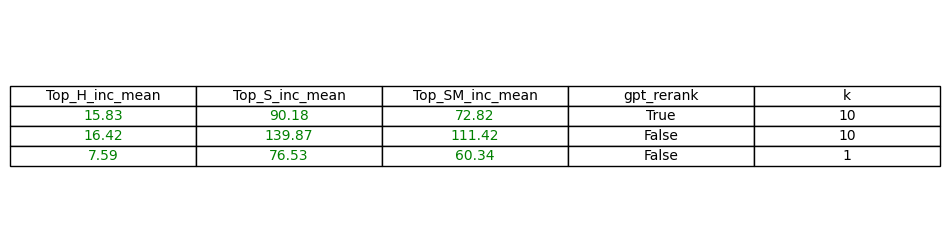

In [27]:
import pandas as pd
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 3))

ax.axis('off')

tbl = ax.table(
    cellText=final_results.values,
    colLabels=final_results.columns,
    loc='center',
    cellLoc='center',
)

apply_formatting(tbl, final_results)  # Applica il colore e l'arrotondamento qui

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

plt.show()
